In [460]:
import tushare as ts
import time
import datetime
import sys
import os
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels
from sklearn.ensemble import RandomForestRegressor
sys.path.append('../Codes')
import DataProcessor as DP
from DataProcessor import centralize
from DataProcessor import standardize
from DataProcessor import standardize_industry
from DataProcessor import get_industrys
from DataProcessor import get_all_industrys
from DataProcessor import get_stock_daily_data
from DataProcessor import get_stock_money_data
from DataProcessor import get_index_data
import tools

In [2]:
pro = ts.pro_api()

In [3]:
#获取行业分类
industrys = DP.get_all_industrys()

In [1499]:
industry = ['801750.SI', '801740.SI', '801080.SI', '801120.SI', '801150.SI']
industry = ['801750.SI']
industry = ['801750.SI', '801740.SI', '801080.SI',]
#取行业内股票数据
data = DP.get_stock_daily_data(industrys=industrys,
                               industry=industry,
                         fields=['open',
                                 'high',
                                 'low',
                                 'close',
                                 'vol',
                                 'amount',
                                 'adj_factor',
                                 'turnover_rate_f',
                                 'pe_ttm',
                                 'pb',
                                 'ps_ttm',
                                 'dv_ttm',
                                 'total_mv'])

money_dic = DP.get_stock_money_data(industrys, industry)
for k in money_dic.keys():
    money_dic[k] = DataFrame(money_dic[k], index=data['open'].index, columns=data['open'].columns)

In [1500]:
st = DP.get_st_data(industrys, industry, data['open'])

In [1501]:
#因子构造
OPEN = np.log(data['open'] * data['adj_factor'])
HIGH = np.log(data['high'] * data['adj_factor'])
LOW = np.log(data['low'] * data['adj_factor'])
CLOSE = np.log(data['close'] * data['adj_factor'])

vol = data['vol']
amount = data['amount']

vwap = (amount / vol * data['adj_factor']).fillna(method='ffill')
vwap = np.log(vwap)

trf = data['turnover_rate_f']
ltrf = np.log(trf)

mv = data['total_mv']
lmv = np.log(mv)

pe = data['pe_ttm']
pb = data['pb']
ps = data['ps_ttm']
pe = 1 / pe
ps = 1 / ps
pb = 1 / pb

dv = data['dv_ttm']

rzrqye = (money_dic['rzye'].fillna(method='ffill') - money_dic['rqye'].fillna(method='ffill')).fillna(method='ffill').loc[OPEN.index, :].fillna(method='ffill')
gt = money_dic['gt_vol'].fillna(method='ffill').loc[OPEN.index, :].fillna(method='ffill')
d_rzrq = rzrqye / rzrqye.shift()
d_rzrq.fillna(1, inplace=True)
d_gt = gt / gt.shift()
d_gt.fillna(1, inplace=True)

In [1502]:
ror = CLOSE - CLOSE.shift()
r_rinei = CLOSE - OPEN
r_geye = OPEN - CLOSE.shift()
rh = HIGH - OPEN
rl = LOW - OPEN
hl = rh - rl
vr = ltrf - ltrf.shift()

In [1503]:
n = 2
#y = standardize_industry(OPEN.shift(-n)-OPEN, industrys, industry)
y = standardize_industry(CLOSE.shift(-n+1)-OPEN, industrys, industry)
y[(r_geye > 0.09).fillna(False) & (r_rinei.abs() < 1e-6).fillna(False)] = 0

In [1504]:
r1 = standardize_industry(ror, industrys, industry)
r2 = standardize_industry(ror.rolling(3).sum(), industrys, industry)
r3 = standardize_industry(ror.rolling(5).sum(), industrys, industry)
r4 = standardize_industry(ror.rolling(10).sum(), industrys, industry)
r5 = standardize_industry(ror.rolling(15).sum(), industrys, industry)

x1 = standardize_industry(r_rinei, industrys, industry)
x2 = standardize_industry(r_rinei.rolling(3).sum(), industrys, industry)
x3 = standardize_industry(r_rinei.rolling(5).sum(), industrys, industry)
x4 = standardize_industry(r_rinei.rolling(10).sum(), industrys, industry)
x5 = standardize_industry(r_rinei.rolling(15).sum(), industrys, industry)

rr1 = standardize_industry((r_rinei / ror), industrys, industry).fillna(0)
rr2 = standardize_industry((r_rinei / ror).rolling(3).sum(), industrys, industry).fillna(0)
rr3 = standardize_industry((r_rinei / ror).rolling(5).sum(), industrys, industry).fillna(0)
rr4 = standardize_industry((r_rinei / ror).rolling(10).sum(), industrys, industry).fillna(0)
rr5 = standardize_industry((r_rinei / ror).rolling(15).sum(), industrys, industry).fillna(0)

z1 = standardize_industry(r_geye, industrys, industry)
z2 = standardize_industry(r_geye.rolling(3).sum(), industrys, industry)
z3 = standardize_industry(r_geye.rolling(5).sum(), industrys, industry)
z4 = standardize_industry(r_geye.rolling(10).sum(), industrys, industry)
z5 = standardize_industry(r_geye.rolling(15).sum(), industrys, industry)

m1 = standardize_industry(np.exp(CLOSE)/np.exp(CLOSE).rolling(3).mean(), industrys, industry)
m2 = standardize_industry(np.exp(CLOSE)/np.exp(CLOSE).rolling(5).mean(), industrys, industry)
m3 = standardize_industry(np.exp(CLOSE)/np.exp(CLOSE).rolling(10).mean(), industrys, industry)
m4 = standardize_industry(np.exp(CLOSE)/np.exp(CLOSE).rolling(15).mean(), industrys, industry)
m5 = standardize_industry(np.exp(CLOSE)/np.exp(CLOSE).rolling(20).mean(), industrys, industry)

h1 = standardize_industry(rh, industrys, industry)
h2 = standardize_industry(rh.rolling(3).sum(), industrys, industry)
h3 = standardize_industry(rh.rolling(5).sum(), industrys, industry)
h4 = standardize_industry(rh.rolling(10).sum(), industrys, industry)
h5 = standardize_industry(rh.rolling(15).sum(), industrys, industry)

l1 = standardize_industry(rl, industrys, industry)
l2 = standardize_industry(rl.rolling(3).sum(), industrys, industry)
l3 = standardize_industry(rl.rolling(5).sum(), industrys, industry)
l4 = standardize_industry(rl.rolling(10).sum(), industrys, industry)
l5 = standardize_industry(rl.rolling(15).sum(), industrys, industry)

hl1 = standardize_industry(hl, industrys, industry)
hl2 = standardize_industry(hl.rolling(3).sum(), industrys, industry)
hl3 = standardize_industry(hl.rolling(5).sum(), industrys, industry)
hl4 = standardize_industry(hl.rolling(10).sum(), industrys, industry)
hl5 = standardize_industry(hl.rolling(15).sum(), industrys, industry)

vr1 = standardize_industry(vr, industrys, industry)
vr2 = standardize_industry(vr.rolling(3).sum(), industrys, industry)
vr3 = standardize_industry(vr.rolling(5).sum(), industrys, industry)
vr4 = standardize_industry(vr.rolling(10).sum(), industrys, industry)
vr5 = standardize_industry(vr.rolling(15).sum(), industrys, industry)


rzrq1 = standardize_industry(d_rzrq, industrys, industry).fillna(0)
rzrq2 = standardize_industry(d_rzrq.rolling(3).sum(), industrys, industry).fillna(0)
rzrq3 = standardize_industry(d_rzrq.rolling(5).sum(), industrys, industry).fillna(0)
rzrq4 = standardize_industry(d_rzrq.rolling(10).sum(), industrys, industry).fillna(0)
rzrq5 = standardize_industry(d_rzrq.rolling(15).sum(), industrys, industry).fillna(0)

gt1 = standardize_industry(d_gt, industrys, industry).fillna(0)
gt2 = standardize_industry(d_gt.rolling(3).sum(), industrys, industry).fillna(0)
gt3 = standardize_industry(d_gt.rolling(5).sum(), industrys, industry).fillna(0)
gt4 = standardize_industry(d_gt.rolling(10).sum(), industrys, industry).fillna(0)
gt5 = standardize_industry(d_gt.rolling(15).sum(), industrys, industry).fillna(0)

pe = standardize_industry(pe, industrys, industry)
pb = standardize_industry(pb, industrys, industry)
ps = standardize_industry(ps, industrys, industry)
dv = standardize_industry(dv, industrys, industry)
lmv = standardize_industry(lmv, industrys, industry)

vwap1 = np.log(((amount * data['adj_factor']) / vol).fillna(method='ffill'))
vwap2 = np.log(((amount * data['adj_factor']).rolling(3).sum() / vol.rolling(3).sum()).fillna(method='ffill'))
vwap3 = np.log(((amount * data['adj_factor']).rolling(5).sum() / vol.rolling(5).sum()).fillna(method='ffill'))
vwap4 = np.log(((amount * data['adj_factor']).rolling(10).sum() / vol.rolling(10).sum()).fillna(method='ffill'))
vwap5 = np.log(((amount * data['adj_factor']).rolling(15).sum() / vol.rolling(15).sum()).fillna(method='ffill'))

ao = standardize_industry(vwap1-OPEN, industrys, industry)

ca1 = standardize_industry(CLOSE-vwap1, industrys, industry)
ca2 = standardize_industry(CLOSE-vwap2, industrys, industry)
ca3 = standardize_industry(CLOSE-vwap3, industrys, industry)
ca4 = standardize_industry(CLOSE-vwap4, industrys, industry)
ca5 = standardize_industry(CLOSE-vwap5, industrys, industry)

rv1 = standardize_industry((ror*vr).abs() * np.sign(ror), industrys, industry)
rv2 = standardize_industry((ror.rolling(3).sum()*vr.rolling(3).sum()).abs() * np.sign(ror.rolling(3).sum()), industrys, industry)
rv3 = standardize_industry((ror.rolling(5).sum()*vr.rolling(5).sum()).abs() * np.sign(ror.rolling(5).sum()), industrys, industry)
rv4 = standardize_industry((ror.rolling(10).sum()*vr.rolling(10).sum()).abs() * np.sign(ror.rolling(10).sum()), industrys, industry)
rv5 = standardize_industry((ror.rolling(15).sum()*vr.rolling(15).sum()).abs() * np.sign(ror.rolling(15).sum()), industrys, industry)

In [1761]:
n_zhichengzuli = 60
HH = HIGH.rolling(n_zhichengzuli).max()
LL = LOW.rolling(n_zhichengzuli).min()
w = (CLOSE - LL) / (HH - LL)
w = standardize_industry(w, industrys, industry)
w.fillna(0, inplace=True)

In [1771]:
r_market = ror.mean(1)
#回归天数
n_reg = 20
tmp = [{k:ror.loc[:, industrys[i]].mean(1) for k in industrys[i]} for i in industry]
tmp1 = {}
for d in tmp:
    tmp1.update(d)

def reg(y, x, n):
    lxx = (x**2).rolling(n).sum() - n * (x.rolling(n).mean()**2)
    lxy = (x * y).rolling(n).sum() - n * x.rolling(n).mean() * y.rolling(n).mean()
    b = lxy / lxx
    a = y.rolling(n).mean() - b * x.rolling(n).mean()
    
    return a, b

a, b = reg(DataFrame(ror), DataFrame(tmp1), n_reg)
e = DataFrame(ror) - a - b * DataFrame(tmp1)

a = standardize_industry(a, industrys, industry)
b = standardize_industry(b, industrys, industry)
std_e = standardize_industry(e.rolling(n_reg).std(), industrys, industry)

sk = a.rolling(n_reg).skew()
ku = a.rolling(n_reg).kurt()
sk = standardize_industry(sk, industrys, industry)
ku = standardize_industry(ku, industrys, industry)

#b = (n_reg * ror.rolling(n_reg).mean().mul(r_market.rolling(n_reg).mean(), 0) - (ror.mul(r_market, 0)).rolling(n_reg).sum()) / (n_reg * ror.rolling(n_reg).mean()**2 - (ror**2).rolling(n_reg).sum())
#a = (-b * ror.rolling(n_reg).mean()).add(r_market.rolling(n_reg).mean(), 0)

In [1772]:
factor = {
    'x1':x1, 'x2':x2, 'x3':x3, 'x4':x4, 'x5':x5,
    'z1':z1, 'z2':z2, 'z3':z3, 'z4':z4, 'z5':z5,
    'r1':r1, 'r2':r2, 'r3':r3, 'r4':r4, 'r5':r5,
    'rr1':rr1, 'rr2':rr2, 'rr3':rr3, 'rr4':rr4, 'rr5':rr5,
    'm1':m1, 'm2':m2, 'm3':m3, 'm4':m4, 'm5':m5,
    'h1':h1, 'h2':h2, 'h3':h3, 'h4':h4, 'h5':h5,
    'l1':l1, 'l2':l2, 'l3':l3, 'l4':l4, 'l5':l5,
    'hl1':hl1, 'hl2':hl2, 'hl3':hl3, 'hl4':hl4, 'hl5':hl5,
    'ao':ao,
    'ca1':ca1, 'ca2':ca2, 'ca3':ca3, 'ca4':ca4, 'ca5':ca5,
    'vr1':vr1, 'vr2':vr2, 'vr3':vr3, 'vr4':vr4, 'vr5':vr5,
    'rv1':rv1, 'rv2':rv2, 'rv3':rv3, 'rv4':rv4, 'rv5':rv5,
    'rzrq1':rzrq1, 'rzrq2':rzrq2, 'rzrq3':rzrq3, 'rzrq4':rzrq4, 'rzrq5':rzrq5,
    'gt1':gt1, 'gt2':gt2, 'gt3':gt3, 'gt4':gt4, 'gt5':gt5,
    'pe':pe, 'pb':pb, 'ps':ps, 'dv':dv, 'lmv':lmv,
    'a':a, 'b':b, 'std_e':std_e,
    'w':w,
    'sk':sk, 'ku':ku,
}

In [1773]:
for k in factor.keys():
    df = DataFrame(factor[k])
    df[st] = 0
    #df[st] = DataFrame({stock:df.mean(1) for stock in df.columns})
    factor[k] = DataFrame(df)

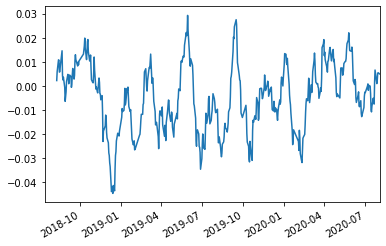

In [1745]:
ic, ir = tools.icir(ku.shift().iloc[-500:,:], y.iloc[-500:,:], n=20)
ic.rolling(20).mean().plot()
#statsmodels.graphics.tsaplots.plot_acf(ic)

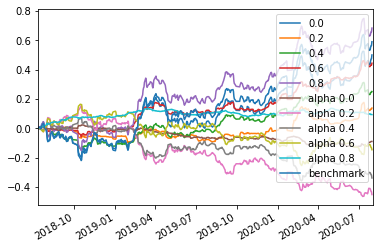

In [1814]:
tools.group_backtest((gt2).shift().iloc[-500:,:], ((CLOSE.shift(-n+1)-OPEN) / n).iloc[-500:,:], n=5)

In [1965]:
begin_date = '2017-01-01'
split_date = '2019-01-01'
train_date = y.index[(begin_date < y.index) & (y.index < split_date)]
test_date = y.index[y.index > split_date]

In [1966]:
df_y_train = DataFrame({'y':y.loc[train_date, :].values.flatten()})
df_x_train = DataFrame({k:factor[k].loc[train_date, :].fillna(0).shift().values.flatten() for k in factor.keys()})
df_y_test = DataFrame({'y':y.loc[test_date, :].values.flatten()})
df_x_test = DataFrame({k:factor[k].loc[test_date, :].fillna(0).shift().values.flatten() for k in factor.keys()})
df_train = pd.concat([df_y_train, df_x_train], axis=1)
df_test = pd.concat([df_y_test, df_x_test], axis=1)

In [1967]:
#df_x_train.loc[:,['ca1', 'ca5', 'ao', 'a', 'b', 'std_e', 'pe', 'lmv', 'gt2', 'sk', 'ku']].corr()

In [1968]:
model = smf.ols('y~ca1+ao\
                  +a+b+std_e\
                  +pe\
                  +lmv\
                  +gt2\
                  +ku\
                  ', data=df_train).fit()
model.tvalues

Intercept    -6.468789
ca1         -19.654213
ao            7.813840
a            -5.917210
b            11.256084
std_e        -3.852623
pe            6.943378
lmv          -4.057959
gt2           2.791413
ku           -2.775104
dtype: float64

300674.SZ    0.160317
300600.SZ    0.153471
002766.SZ    0.147235
002288.SZ    0.130921
000662.SZ    0.125315
300167.SZ    0.121675
300150.SZ    0.120876
300202.SZ    0.118127
300136.SZ    0.113749
002935.SZ    0.111947
Name: 2018-12-28 00:00:00, dtype: float64


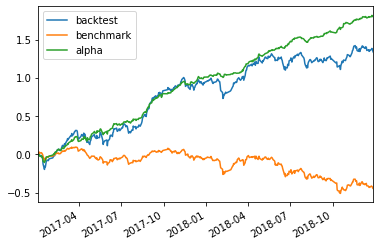

In [1969]:
#调仓周期
y_hat = DataFrame(model.predict(df_train).values.reshape(len(train_date), len(y.columns)), index=train_date, columns=y.columns)
q = 0.98
position = (y_hat.gt(y_hat.quantile(q, 1), 0)) & (y_hat.lt(y_hat.quantile(1, 1), 0))

ror_train = ror.loc[train_date, :]
r_rinei_train = r_rinei.loc[train_date, :]
r_geye_train = r_geye.loc[train_date, :]

#ror_huice = (position * (CLOSE - OPEN).loc[train_date, :] + position.shift() * (OPEN - CLOSE.shift()).loc[train_date, :]).mul(len(y.columns) / position.sum(1), 0)
ror_huice = (position * (CLOSE - OPEN).loc[train_date, :] + position.shift() * (CLOSE - CLOSE.shift()).loc[train_date, :]).mul(len(y.columns) / position.sum(1), 0) / n
#ror_huice = (position * (CLOSE.shift(-n+1) - OPEN).loc[train_date, :]).mul(len(y.columns) / position.sum(1), 0) / n

ror_huice.mean(1).cumsum().plot()

benchmark = ror_train
benchmark.mean(1).cumsum().plot()

alpha = ror_huice.mean(1) - benchmark.mean(1)
alpha.cumsum().plot()
'''
for i in industry:
    stock = industrys[i]
    ror_test.loc[:,stock].mean(1).cumsum().plot()
plt.legend(['backtest', 'benchmark', 'alpha'] + [i for i in industry])
'''
plt.legend(['backtest', 'benchmark', 'alpha'])
print(y_hat.iloc[-1,:].sort_values(ascending=False).dropna().iloc[:10])

002151.SZ    0.128191
601519.SH    0.124372
300232.SZ    0.123085
600391.SH    0.110722
002981.SZ    0.109304
002845.SZ    0.103642
002384.SZ    0.102053
603890.SH    0.098335
300033.SZ    0.094818
300552.SZ    0.093603
Name: 2020-08-03 00:00:00, dtype: float64


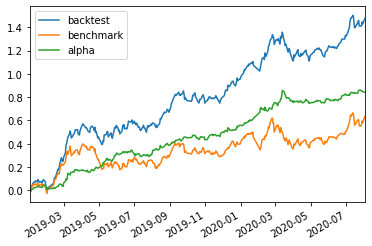

In [1970]:
#调仓周期
y_hat = DataFrame(model.predict(df_test).values.reshape(len(test_date), len(y.columns)), index=test_date, columns=y.columns)
q1 = 0.98
q2 = 1
position = (y_hat.gt(y_hat.quantile(q1, 1), 0)) & (y_hat.lt(y_hat.quantile(q2, 1), 0))

ror_test = ror.loc[test_date, :]
r_rinei_test = r_rinei.loc[test_date, :]
r_geye_test = r_geye.loc[test_date, :]

#ror_huice = (position * (CLOSE - OPEN).loc[test_date, :]).mul(len(y.columns) / position.sum(1), 0)
ror_huice = (position * (CLOSE - OPEN).loc[test_date, :] + position.shift() * (CLOSE - CLOSE.shift()).loc[test_date, :]).mul(len(y.columns) / position.sum(1), 0) / n
#ror_huice = (position * (CLOSE.shift(-n+1) - OPEN).loc[test_date, :]).mul(len(y.columns) / position.sum(1), 0) / n


ror_huice.mean(1).cumsum().plot()

benchmark = ror_test
benchmark.mean(1).cumsum().plot()

alpha = ror_huice.mean(1) - benchmark.mean(1)
alpha.cumsum().plot()
'''
for i in industry:
    stock = industrys[i]
    ror_test.loc[:,stock].mean(1).cumsum().plot()
plt.legend(['backtest', 'benchmark', 'alpha'] + [i for i in industry])
'''
plt.legend(['backtest', 'benchmark', 'alpha'])
print(y_hat.iloc[-1,:].sort_values(ascending=False).dropna().iloc[:10])

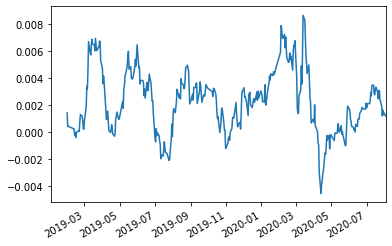

In [1971]:
alpha.rolling(20).mean().plot()

In [1972]:
position.sum(1)

2019-01-02     0
2019-01-03    10
2019-01-04    10
2019-01-07    10
2019-01-08    10
              ..
2020-07-28    10
2020-07-29    10
2020-07-30    10
2020-07-31    10
2020-08-03    10
Length: 385, dtype: int64

In [1973]:
#((ror_huice).mean(1)-0.0007+1).cumprod().plot()

In [1974]:
ror_huice.mean(1).mean() / ror_huice.mean(1).std() * np.sqrt(len(ror_huice))

3.2969209106662527

In [1975]:
#(benchmark.mean(1)+1).cumprod().plot()

In [1976]:
df_y_test2 = DataFrame({'y':y.loc[test_date, :].values.flatten()})
df_x_test2 = DataFrame({k:factor[k].loc[test_date, :].fillna(0).values.flatten() for k in factor.keys()})
df_test2 = pd.concat([df_y_test2, df_x_test2], axis=1)
y_hat2 = DataFrame(model.predict(df_test2).values.reshape(len(ror_test), len(ror_test.columns)), index=ror_test.index, columns=ror_test.columns)
print(y_hat2.iloc[-1,:].sort_values(ascending=False).dropna().iloc[:10])

300552.SZ    0.102368
300686.SZ    0.097856
300433.SZ    0.095471
002161.SZ    0.092154
300241.SZ    0.091394
000823.SZ    0.079252
300682.SZ    0.076393
300527.SZ    0.076136
002530.SZ    0.073328
300248.SZ    0.073146
Name: 2020-08-03 00:00:00, dtype: float64


In [1977]:
print(y_hat2.iloc[-2,:].sort_values(ascending=False).dropna().iloc[:10])

002151.SZ    0.128191
601519.SH    0.124372
300232.SZ    0.123085
600391.SH    0.110722
002981.SZ    0.109304
002845.SZ    0.103642
002384.SZ    0.102053
603890.SH    0.098335
300033.SZ    0.094818
300552.SZ    0.093603
Name: 2020-07-31 00:00:00, dtype: float64


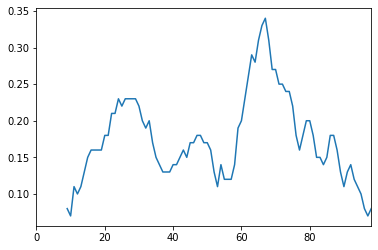

In [1935]:
Series([len(y_hat2.iloc[-i,:].sort_values(ascending=False).dropna().iloc[:10].index & y_hat2.iloc[-i-1,:].sort_values(ascending=False).dropna().iloc[:10].index)/10 for i in range(1,100)]).rolling(10).mean().plot()

In [368]:
model = RandomForestRegressor(n_estimators=10).fit(df_train.iloc[:, 1:], df_train.iloc[:, 0])
model.feature_importances_

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [386]:
Series([1,2,3]).rename('1').name

'1'

In [387]:
factor = DataFrame(np.arange(12).reshape(3,4))

In [404]:
factor.apply(lambda a:Series(rankdata(a)), axis=1)

,0,1,2,3
0,4.0,1.0,2.0,3.0
1,1.0,2.0,3.0,4.0
2,1.0,2.0,3.0,4.0


In [390]:
factor.iloc[0,0] = 100

In [393]:
factor

,0,1,2,3
0,100,1,2,3
1,4,5,6,7
2,8,9,10,11


In [398]:
a=[200, 1,2,3]

In [399]:
sorted(range(len(a)), key = a.__getitem__)

[1, 2, 3, 0]

In [400]:
from scipy.stats import rankdata

In [401]:
rankdata(a)

array([4., 1., 2., 3.])

In [403]:
rankdata(factor)

array([12.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.])

In [409]:
s = Series([1,2]).rename(11)

In [410]:
DataFrame(s)

,11
0,1
1,2


In [622]:
df = DataFrame(np.arange(12).reshape(3,4))

In [623]:
df2 = df + 1

In [627]:
df2.divide(df)

,0,1,2,3
0,inf,2.000000,1.500000,1.333333
1,1.250,1.200000,1.166667,1.142857
2,1.125,1.111111,1.100000,1.090909


In [671]:
df = pro.us_basic()

In [672]:
df

,ts_code,name,classify,list_date,delist_date
0,ONCY,None,EQT,20011005,None
1,SCCO,None,EQT,19950124,None
2,KAOCF,None,EQT,19740319,None
3,BOIRF,None,EQT,19880628,None
4,SDXOF,None,EQT,19830304,None
...,...,...,...,...,...
5995,ESESQ,None,EQT,20031014,None
5996,TRKX,None,EQT,20000718,None
5997,ELAMF,None,EQT,19960320,None
5998,CZNB,None,EQT,20120724,None


In [680]:
O = DataFrame()
C = DataFrame()
for stock in df.ts_code:
    tmp = pro.us_daily(ts_code=stock, start_date='20100101', end_date='20200101').set_index('trade_date')
    time.sleep(30)
    O.loc[:,stock] = tmp.open
    C.loc[:,stock] = tmp.close

KeyboardInterrupt: 

In [689]:
C.fillna(method='ffill')

,ONCY,SCCO,KAOCF,BOIRF,SDXOF,ODMUF,CHJHF,DBOXF,IMNPQ,CYUFF,...,ABCE,BWEN,PYT,ICBT,HOSZY,ICE,AQSP,YHDT,OSUR,PSBQ
trade_date,,,,,,,,,,,,,,,,,,,,,
20191231,4.76,42.48,NaN,NaN,NaN,NaN,0.55,0.08,0.00,NaN,...,0.00,1.66,NaN,NaN,NaN,92.55,2.50,NaN,8.03,27.50
20191230,3.87,42.49,NaN,NaN,NaN,NaN,0.40,0.08,0.00,NaN,...,0.00,1.65,NaN,NaN,NaN,92.44,2.77,NaN,7.81,27.50
20191227,2.84,42.57,NaN,NaN,NaN,NaN,0.40,0.08,0.00,NaN,...,0.00,1.65,23.13,NaN,NaN,93.00,2.70,NaN,7.92,27.50
20191226,2.82,43.19,NaN,NaN,NaN,NaN,0.40,0.09,0.00,NaN,...,0.00,1.69,22.33,NaN,NaN,92.87,2.70,NaN,8.01,27.50
20191224,1.83,42.59,NaN,NaN,NaN,NaN,0.40,0.09,0.00,NaN,...,0.00,1.70,22.99,NaN,NaN,92.19,2.51,NaN,8.29,27.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20100108,2.94,36.26,24.74,45.9,58.48,1.64,0.47,0.34,0.64,2.85,...,0.02,7.34,18.74,0.0,NaN,108.48,3.25,0.2,4.95,16.50
20100107,2.87,35.56,24.74,45.9,58.15,1.64,0.47,0.34,0.64,2.85,...,0.02,7.43,18.73,0.0,NaN,108.14,3.25,0.2,4.88,16.50
20100106,2.92,35.90,24.74,45.9,60.23,1.64,0.47,0.34,0.63,2.85,...,0.02,7.05,18.45,0.0,NaN,105.27,3.25,0.2,4.94,15.05


In [695]:
O=O.sort_index()
C=C.sort_index()

In [717]:
rgeye=(O/C.shift()-1).fillna(0)
rgeye[rgeye==np.inf]=0
rgeye[rgeye>5]=0
rgeye[rgeye<-5]=0

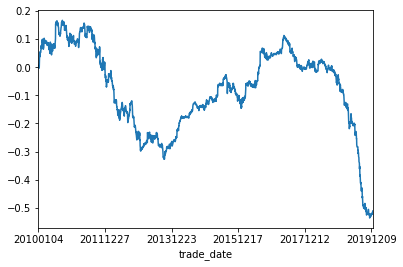

In [718]:
rgeye.mean(1).cumsum().plot()

In [704]:
rgeye.max()

ONCY     9.189189
SCCO     0.050389
KAOCF    0.048622
BOIRF    0.025781
SDXOF    0.113889
           ...   
ICE      0.058221
AQSP     1.750000
YHDT     1.352941
OSUR     0.214545
PSBQ     0.166667
Length: 77, dtype: float64

In [688]:
rgeye

,ONCY,SCCO,KAOCF,BOIRF,SDXOF,ODMUF,CHJHF,DBOXF,IMNPQ,CYUFF,...,ABCE,BWEN,PYT,ICBT,HOSZY,ICE,AQSP,YHDT,OSUR,PSBQ
trade_date,,,,,,,,,,,,,,,,,,,,,
20191231,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0,0.000000,0.000000,0.0,0.000000,0.000000
20191230,-0.399160,0.002119,0.0,0.0,0.000000,0.0,-0.272727,-0.125,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0,0.005727,0.108000,0.0,-0.012453,-0.014182
20191227,-0.320413,0.020946,0.0,0.0,0.000000,0.0,0.000000,0.000,0.000000,0.0,...,0.0,0.024242,0.000000,0.0,0,0.006166,-0.025271,0.0,0.029449,-0.007273
20191226,-0.348592,0.004933,0.0,0.0,0.000000,0.0,0.000000,0.000,0.000000,0.0,...,0.0,0.042424,-0.009511,0.0,0,-0.005806,0.000000,0.0,0.049242,0.000000
20191224,-0.375887,-0.009030,0.0,0.0,0.000000,0.0,0.000000,0.000,0.000000,0.0,...,0.0,0.029586,0.029557,0.0,0,-0.005061,0.125926,0.0,0.049938,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20100108,-0.003436,-0.019559,0.0,0.0,0.000000,0.0,0.000000,0.000,-0.247059,0.0,...,0.0,0.031989,0.005365,0.0,0,-0.007281,0.000000,0.0,-0.043222,0.000000
20100107,-0.013605,-0.015168,0.0,0.0,-0.005643,0.0,0.000000,0.000,0.000000,0.0,...,0.0,-0.038147,-0.012807,0.0,0,-0.034200,0.000000,0.0,0.000000,0.000000
20100106,0.020906,-0.014904,0.0,0.0,0.037317,0.0,0.000000,0.000,-0.031250,0.0,...,0.0,0.014805,-0.034170,0.0,0,-0.008692,0.000000,0.0,0.043033,0.000000


In [635]:
df = DataFrame(np.arange(12).reshape(3, 4))

In [640]:
df2 = df + 1
df.iloc[-1,-1] = 0

In [641]:
df.iloc[-6:,:].corrwith(df2.iloc[-6:,:])

0    1.000000
1    1.000000
2    1.000000
3   -0.427121
dtype: float64

In [273]:
gt1.apply(lambda x:(np.abs(x)>1e-6).any())

000066.SZ    True
000977.SZ    True
002063.SZ    True
002152.SZ    True
002153.SZ    True
             ... 
603976.SH    True
002923.SZ    True
002898.SZ    True
002880.SZ    True
300725.SZ    True
Length: 932, dtype: bool

In [274]:
gt1.sum()

000066.SZ      3.058870
000977.SZ      1.247908
002063.SZ     16.045800
002152.SZ    -29.453465
002153.SZ     -5.858971
                ...    
603976.SH    -46.050127
002923.SZ    -46.050127
002898.SZ    -46.050127
002880.SZ    -20.518216
300725.SZ    102.406118
Length: 932, dtype: float64

In [281]:
gt.notna().any()

000066.SZ     True
000977.SZ     True
002063.SZ     True
002152.SZ     True
002153.SZ     True
             ...  
603976.SH    False
002923.SZ    False
002898.SZ    False
002880.SZ     True
300725.SZ     True
Length: 932, dtype: bool